## Задание 2

### Ноутбук от начала до конца на моей машине запускается за 8 минут

Вам необходимо построить модель, которая на основании данных, поступающих каждую минуту, определяют качество продукции, производимое на обжиговой машине.

Обжиговая машина представляет собой агрегат, состоящий из 5 одинаковых по размеру камер, в каждой камере установлено по 3 датчика температур. Кроме этого, для данной задачи Вы собрали данные о высоте слоя сырья и его влажности. Высота слоя и влажность измеряются при входе сырья в машину. Сырье проходит через обжиговую машину за час.

Данные с показателями работы обжиговой машины содержатся в файле X_data.csv:

Качество продукции измеряется в лаборатории по пробам, которые забираются каждый час, данные по известным анализам содержатся в файле Y_train.csv. В файле указано время забора пробы, проба забирается на выходе из обжиговой машины.

Вы договорились с заказчиком, что оценкой модели будет являться показатель MAE, для оценки модели необходимо сгенерировать предсказания за период, указанный в файле Y_submit.csv (5808 предиктов).

**Импортируем библиотеки**

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

%matplotlib inline

- make_dataframe - создает датафрейм из конкатенации y_train, y_submit и мержа этой таблицы с x_train, попутно выкидывая из него все пропущенные значения
- make_lag_features - генерация лаговых фич на 1, 2, 3, 4, 5, 6, 12, 24 и rolling mean
- lr_cross_val, rf_cross_val, xgb_cross_val, lgb_cross_val, catboost_cross_val - оценка регрессоров на кросс-валидации + графики feature importances и распределения предиктов

In [2]:
default_features = ['T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'T_data_2_1',
       'T_data_2_2', 'T_data_2_3', 'T_data_3_1', 'T_data_3_2', 'T_data_3_3',
       'T_data_4_1', 'T_data_4_2', 'T_data_4_3', 'T_data_5_1', 'T_data_5_2',
       'T_data_5_3', 'H_data', 'AH_data']

def make_dataframe():
    x_train = pd.read_csv('X_data.csv', sep=';', \
                          names=['time']+default_features, header=0, parse_dates=['time'])
    print('X_train table shape=', x_train.shape)
    y_train = pd.read_csv('Y_train.csv', sep=';', names=['time', 'target'], parse_dates=['time'])
    print('Y_train table shape=', y_train.shape)
    y_submit = pd.read_csv('Y_submit.csv', sep=';', names=['time', 'target'], parse_dates=['time'])
    print('Y_submit table shape=', y_submit.shape)
    concat = pd.concat([y_train, y_submit]).reset_index(drop=True)
    print('Y_train & Y_submit concat table shape=', concat.shape)
    df = pd.merge(x_train, concat, how='outer', on=['time']).reset_index(drop=True)
    print('X_train & cocat merged table shape=', df.shape)
    print('Number of rows with NaN={}, drop rate={}'.format(df.target.isna().sum(), \
                                                            df.target.isna().sum()/df.shape[0]))
    df = df.dropna().reset_index(drop=True).set_index('time')
    print('Dataframe shape before feature engineering=', df.shape)
    del x_train, y_train, y_submit, concat
    return df

def make_lag_features(df):
    df_y = df['target']
    df_X = df.copy().drop('target', axis=1)
    for i, column in enumerate(default_features):
        df_X[str(column)+'_lag_1'] = df_X[column].shift(1)
        df_X[str(column)+'_lag_2'] = df_X[column].shift(2)
        df_X[str(column)+'_lag_3'] = df_X[column].shift(3)
        df_X[str(column)+'_lag_4'] = df_X[column].shift(4)
        df_X[str(column)+'_lag_5'] = df_X[column].shift(5)
        df_X[str(column)+'_lag_6'] = df_X[column].shift(6)
        df_X[str(column)+'_lag_12'] = df_X[column].shift(12)
        df_X[str(column)+'_lag_24'] = df_X[column].shift(24)
    print('{} lag features were created'.format(i*8))
    df = pd.merge(df_X.reset_index(), df_y.reset_index(), how='outer', on=['time']).set_index('time')
    print('Final dataframe shape before feature engineering=', df.shape)
    del df_X, df_y
    return df

def lasso_cross_val(X, y, n_splits=5, params=None):
    tscv = TimeSeriesSplit(n_splits)
    i = 0
    scores = []
    for train_index, test_index in tscv.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        regressor = Lasso()
        regressor.fit(X_train, y_train)
        pred = regressor.predict(X_test)
        scores.append(mean_absolute_error(y_test, pred))
        print('Lasso Regression MSE={} MAE={} on fold ={}' \
              .format(mean_squared_error(y_test, pred), scores[i], i+1))
        i += 1
    print()
    print(scores)
    print()
    print('Lasso Regression mean MAE=', sum(scores)/len(scores))
    return regressor

def rf_cross_val(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits)
    i = 0
    scores = []
    for train_index, test_index in tscv.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        regressor = RandomForestRegressor(n_jobs=-1)
        regressor.fit(X_train, y_train)
        pred = regressor.predict(X_test)
        scores.append(mean_absolute_error(y_test, pred))
        print('RFRegressor MSE={} MAE={} on fold ={}' \
              .format(mean_squared_error(y_test, pred), scores[i], i+1))
        i += 1
    print()
    print(scores)
    print()
    print('RFRegressor mean MAE=', sum(scores)/len(scores))
    plt.figure(figsize=(8,7))
    feat_importances = pd.Series(regressor.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title('Feature importances')
    plt.grid()
    plt.show()
    return regressor
    

def xgb_cross_val(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits)
    i = 0
    scores = []
    for train_index, test_index in tscv.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        regressor = XGBRegressor(silent=True, n_jobs=-1)
        regressor.fit(X_train, y_train)
        pred = regressor.predict(X_test)
        scores.append(mean_absolute_error(y_test, pred))
        print('XGBRegressor MSE={} MAE={} on fold ={}' \
              .format(mean_squared_error(y_test, pred), scores[i], i+1))
        i += 1
    print()
    print(scores)
    print()
    print('XGBRegressor mean MAE=', sum(scores)/len(scores))
    plt.figure(figsize=(8,7))
    feat_importances = pd.Series(regressor.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title('Feature importances')
    plt.grid()
    plt.show()
    return regressor

def lgb_cross_val(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits)
    i = 0
    scores = []
    for train_index, test_index in tscv.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        regressor = LGBMRegressor(silent=True, n_jobs=-1)
        regressor.fit(X_train, y_train)
        pred = regressor.predict(X_test)
        scores.append(mean_absolute_error(y_test, pred))
        print('XGBRegressor MSE={} MAE={} on fold ={}' \
              .format(mean_squared_error(y_test, pred), scores[i], i+1))
        i += 1
    print()
    print(scores)
    print()
    print('XGBRegressor mean MAE=', sum(scores)/len(scores))
    plt.figure(figsize=(8,7))
    feat_importances = pd.Series(regressor.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title('Feature importances')
    plt.grid()
    plt.show()
    return regressor

def catboost_cross_val(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits)
    i = 0
    scores = []
    for train_index, test_index in tscv.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        regressor = CatBoostRegressor(silent=True)
        regressor.fit(X_train, y_train)
        pred = regressor.predict(X_test)
        scores.append(mean_absolute_error(y_test, pred))
        print('CatBoostRegressor MSE={} MAE={} on fold ={}' \
              .format(mean_squared_error(y_test, pred), scores[i], i+1))
        i += 1
    print()
    print(scores)
    print()
    print('CatBoostRegressor mean MAE=', sum(scores)/len(scores))
    plt.figure(figsize=(8,7))
    feat_importances = pd.Series(regressor.get_feature_importance(), index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title('Feature importances')
    plt.grid()
    plt.show()
    return regressor

## EDA

Создаем датафрейм и добавляем к нему лаговые фичи

In [3]:
df = make_dataframe()
df = make_lag_features(df)

X_train table shape= (2103841, 18)
Y_train table shape= (29184, 2)
Y_submit table shape= (5808, 2)
Y_train & Y_submit concat table shape= (34992, 2)
X_train & cocat merged table shape= (2103841, 19)
Number of rows with NaN=2068849, drop rate=0.9833675643739237
Dataframe shape before feature engineering= (34992, 18)
128 lag features were created
Final dataframe shape before feature engineering= (34992, 154)


Взглянем на график таргета. Видно, что есть резкие скачки, но при этом есть некоторая конва, около которой и происходят эти колебания, прямая линия в хвосте - то, что мы будем предсказывать

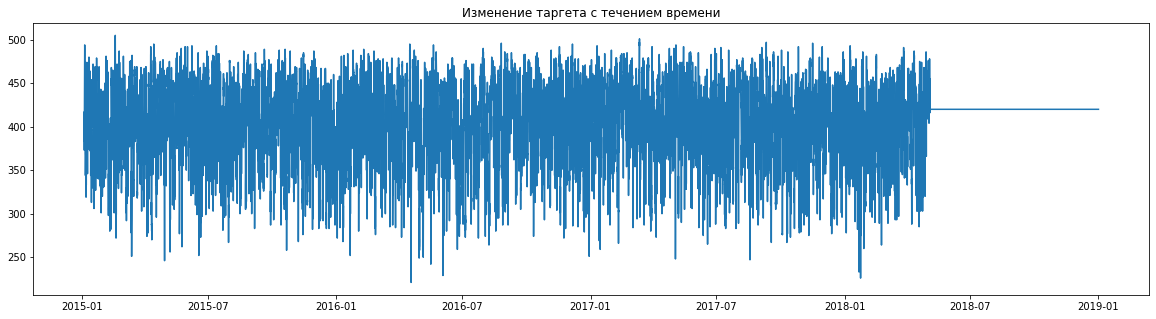

In [4]:
plt.figure(figsize=(20,5))
plt.plot(df.target)
plt.title('Изменение таргета с течением времени')
plt.show()

Делим всю выбороку на тренировочную и тестовую по известной нам дате и времени (которую предскажем в конце)

In [5]:
df_train = df[:'2018-05-03 23:05:00']
df_test = df['2018-05-04 00:05:00':]

In [6]:
df_train[default_features+['target']].describe()

T_data_1_1    T_data_1_2    T_data_1_3    T_data_2_1    T_data_2_2  \
count  29184.000000  29184.000000  29184.000000  29184.000000  29184.000000   
mean     250.034265    249.814179    250.152584    349.803008    349.717893   
std       32.350350     30.453885     30.635287     43.752481     41.414882   
min     -193.000000   -120.000000    -96.000000   -703.000000   -914.000000   
25%      228.000000    228.000000    229.000000    328.000000    328.000000   
50%      250.000000    250.000000    250.000000    350.000000    350.000000   
75%      272.000000    271.000000    272.000000    372.000000    372.000000   
max      722.000000    564.000000    643.000000   1299.000000   1178.000000   

         T_data_2_3    T_data_3_1    T_data_3_2    T_data_3_3    T_data_4_1  \
count  29184.000000  29184.000000  29184.000000  29184.000000  29184.000000   
mean     349.951377    501.162932    500.918037    501.318291    348.956689   
std       38.016812     62.418309     64.634889     61.482540     38.755415   
min     -186.000000   -591.000000   -759.000000   -441.000000   -441.000000   
25%      328.000000    464.000000    463.000000    464.000000    327.000000   
50%      350.000000    502.000000    502.000000    502.000000    349.000000   
75%      372.000000    538.000000    537.000000    539.000000    371.000000   
max      886.000000   1491.000000   2492.000000   1294.000000   1136.000000   

         T_data_4_2   T_data_4_3    T_data_5_1    T_data_5_2    T_data_5_3  \
count  29184.000000  29184.00000  29184.000000  29184.000000  29184.000000   
mean     348.952063    349.67352    249.800644    249.671635    249.848890   
std       40.172444     39.73318     30.780582     30.545967     30.630141   
min     -446.000000   -594.00000    -82.000000   -106.000000   -128.000000   
25%      327.000000    327.00000    229.000000    229.000000    228.000000   
50%      349.000000    350.00000    250.000000    250.000000    250.000000   
75%      371.000000    371.00000    271.000000    271.000000    271.000000   
max     1204.000000    944.00000    879.000000    737.000000    619.000000   

             H_data       AH_data        target  
count  29184.000000  29184.000000  29184.000000  
mean     174.750047      7.500597    402.800747  
std       14.403922      1.146831     46.273228  
min      145.000000      3.120000    221.000000  
25%      162.460000      6.730000    372.000000  
50%      174.400000      7.510000    408.000000  
75%      186.980000      8.280000    439.000000  
max      206.680000     11.620000    505.000000

Посмотрим количество уникальных и пропущенных значений в фичах. Так как пропусков нет, а все значения признаков имеют довольно много значений, то будем считать, что все они принимают вещественные значения

In [7]:
for column in df_train[default_features+['target']]:
    print('{} column has {} unique values and {} NaN values' \
          .format(column, df_train[column].nunique(), df_train[column].isna().sum()))

T_data_1_1 column has 363 unique values and 0 NaN values
T_data_1_2 column has 310 unique values and 0 NaN values
T_data_1_3 column has 312 unique values and 0 NaN values
T_data_2_1 column has 492 unique values and 0 NaN values
T_data_2_2 column has 456 unique values and 0 NaN values
T_data_2_3 column has 463 unique values and 0 NaN values
T_data_3_1 column has 567 unique values and 0 NaN values
T_data_3_2 column has 572 unique values and 0 NaN values
T_data_3_3 column has 590 unique values and 0 NaN values
T_data_4_1 column has 451 unique values and 0 NaN values
T_data_4_2 column has 460 unique values and 0 NaN values
T_data_4_3 column has 464 unique values and 0 NaN values
T_data_5_1 column has 311 unique values and 0 NaN values
T_data_5_2 column has 319 unique values and 0 NaN values
T_data_5_3 column has 332 unique values and 0 NaN values
H_data column has 5441 unique values and 0 NaN values
AH_data column has 803 unique values and 0 NaN values
target column has 264 unique values a

Построим heatmap, чтобы оценить влияние признаков друг на друга. Видим, что показания датчиков, которые находятся в одной камере сильно коррелируют друг с другом, что логично. Примечательно, что показания в датчиках третьей камеры сильно коррелируют с таргетом.

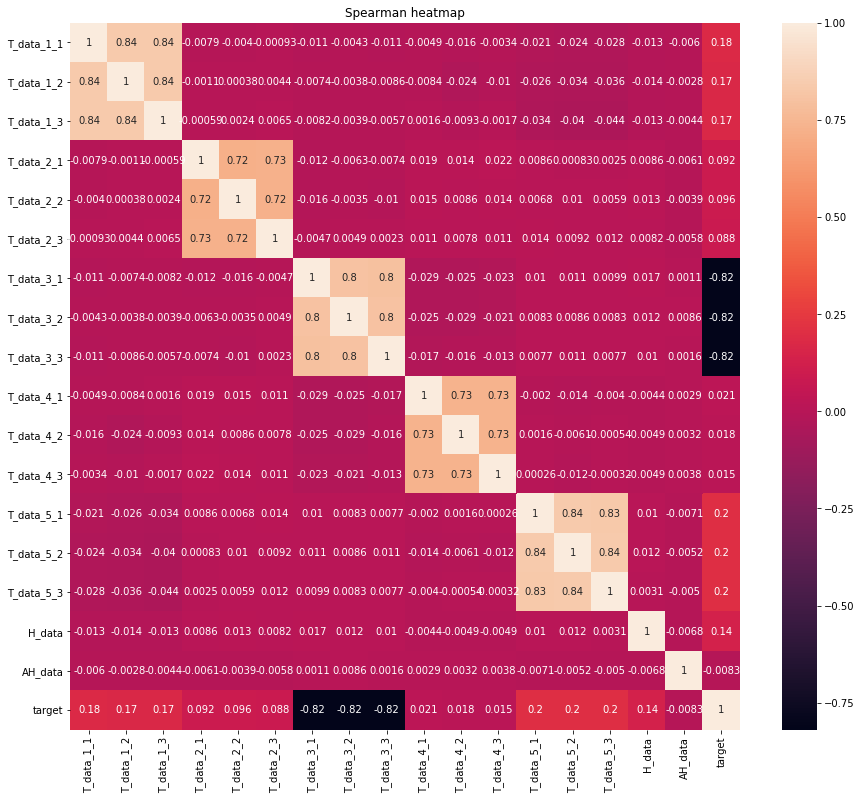

In [8]:
corr = df_train[default_features+['target']].corr(method='spearman')
fig, ax = plt.subplots(figsize=(15,13))
sns.heatmap(corr, annot=True)
plt.title('Spearman heatmap')
plt.show()

Признаки очень интересно друг с другом попарно коррелируют

<Figure size 1440x1296 with 0 Axes>

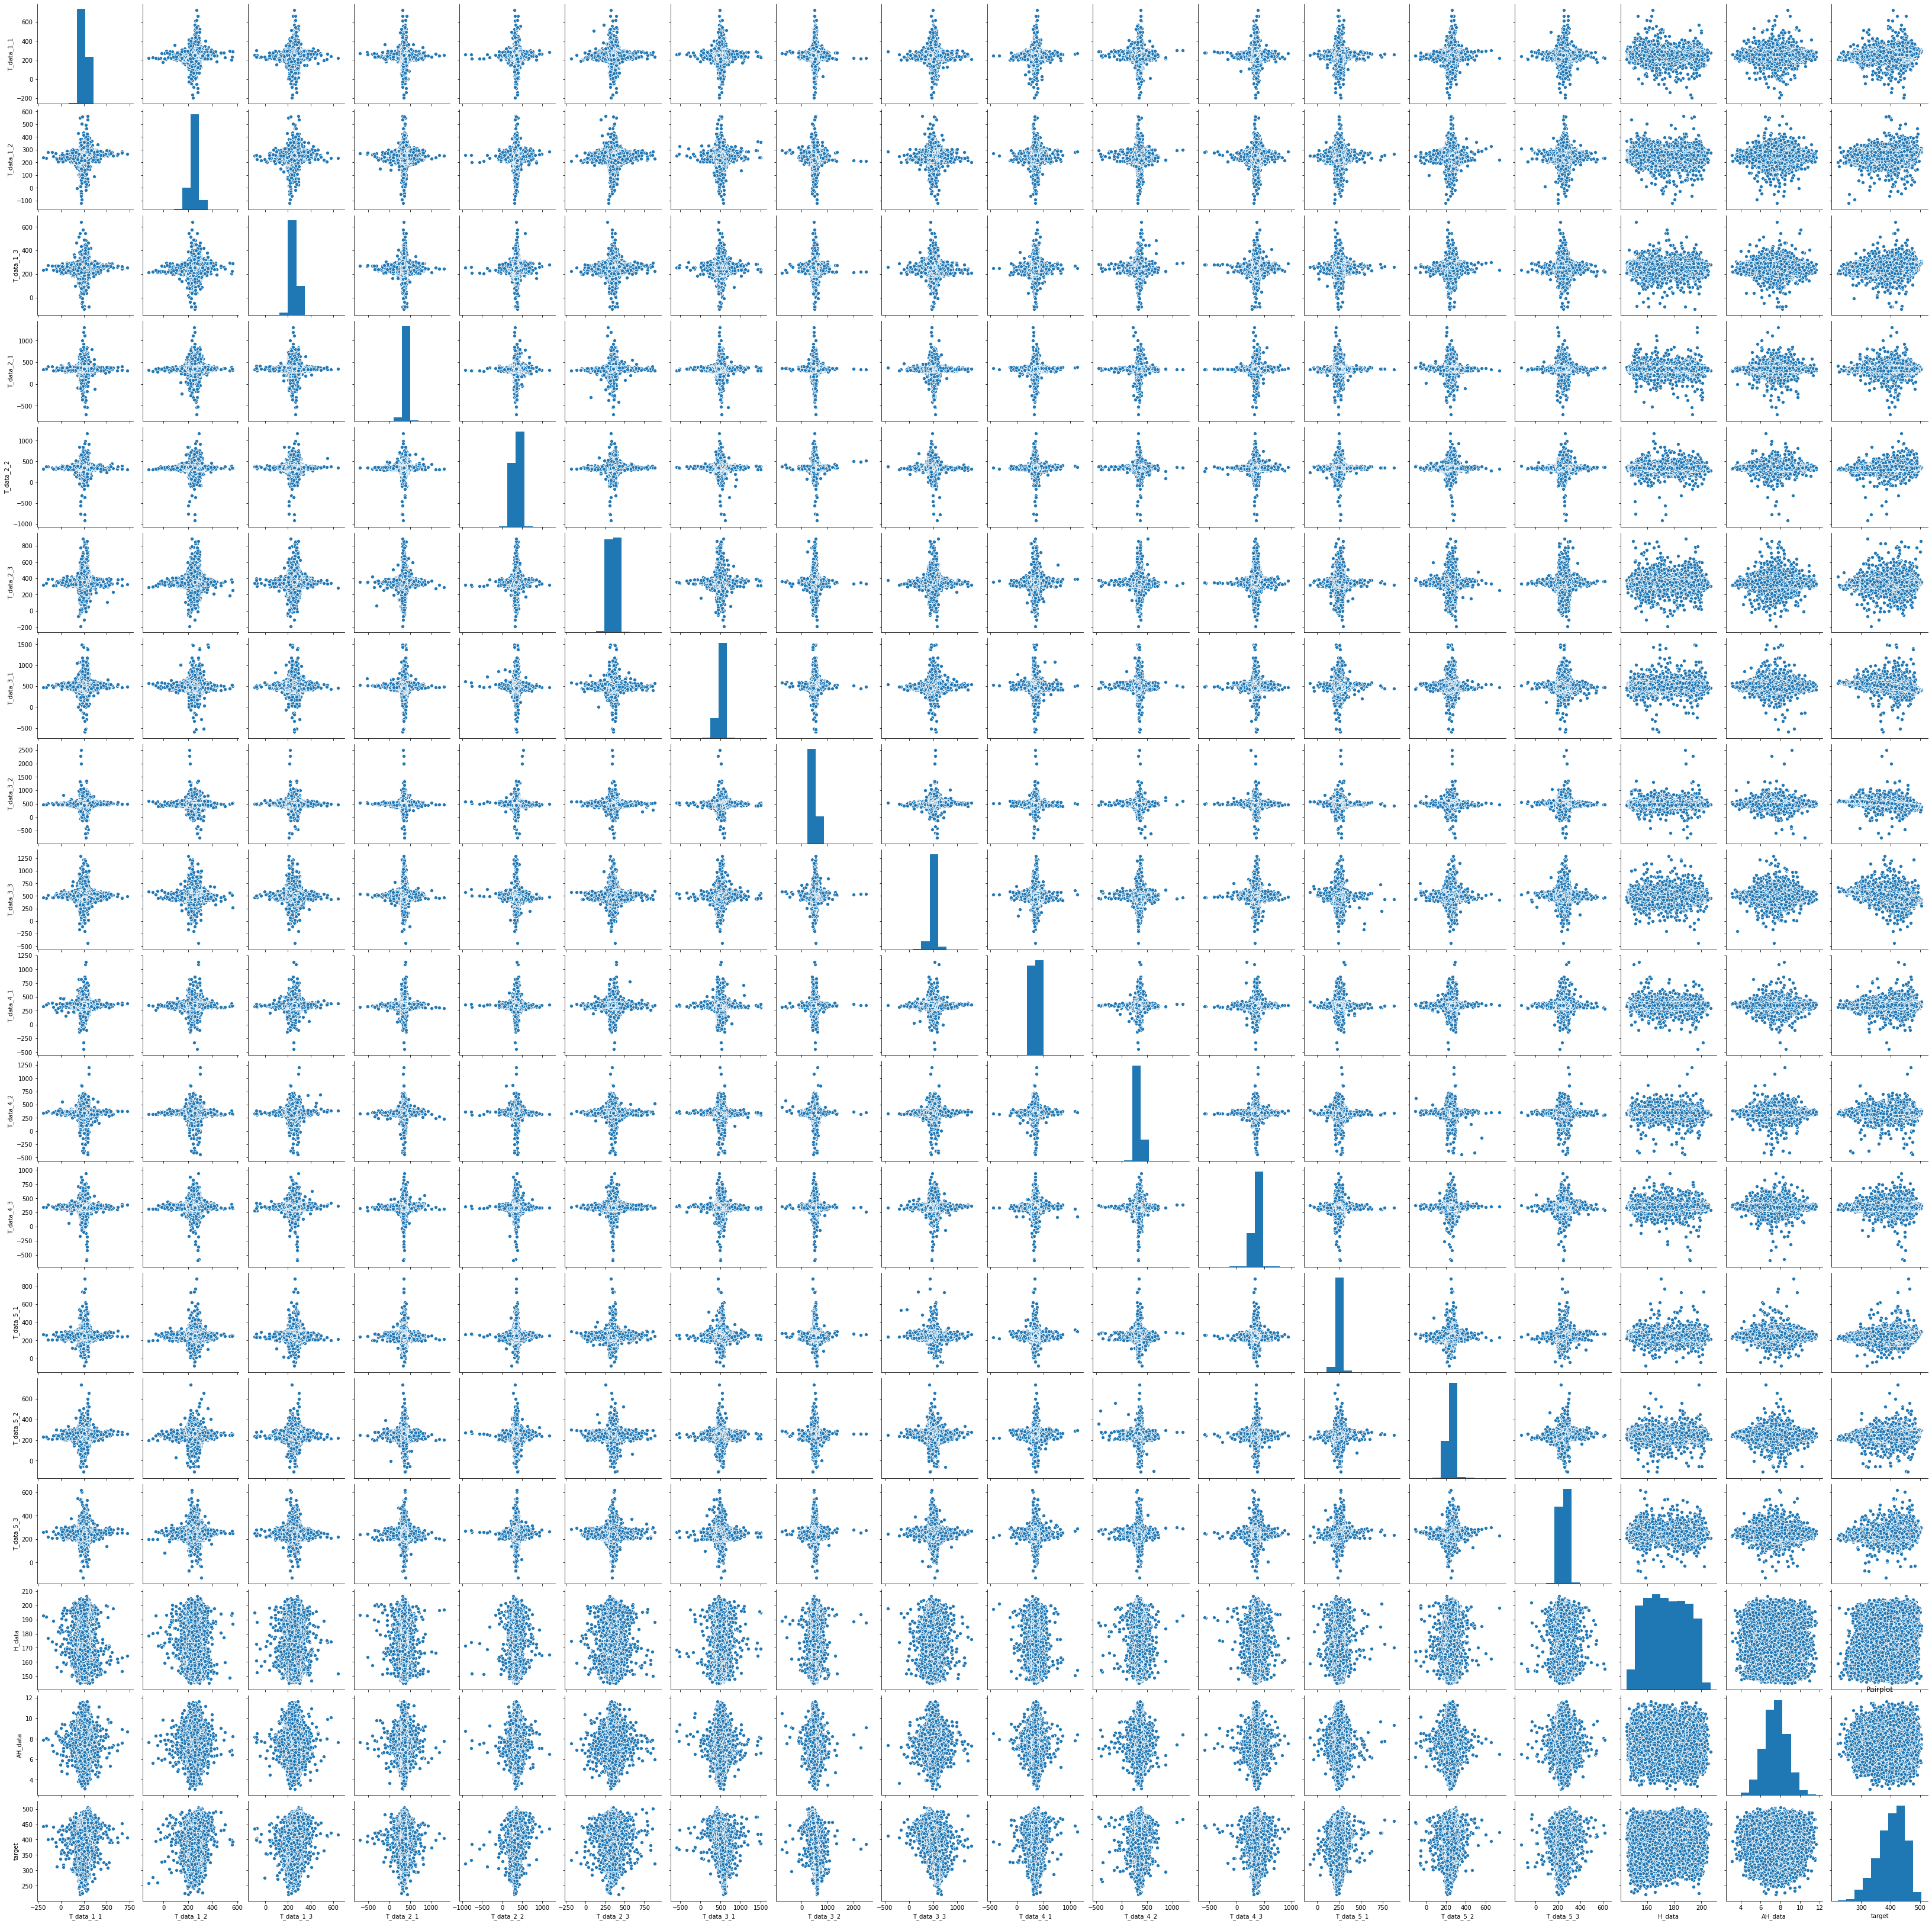

In [9]:
plt.figure(figsize=(20,18))
sns.pairplot(df_train[default_features+['target']])
plt.title('Pairplot')
plt.show()

Распределение значений таргета поближе

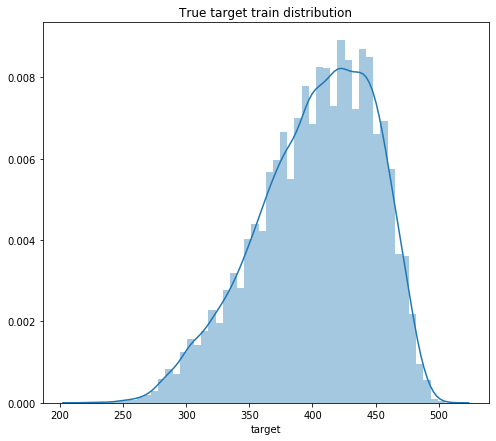

In [10]:
plt.figure(figsize=(8,7))
sns.distplot(df_train['target'])
plt.title('True target train distribution')
plt.show()

## MODELS

Наша тренировочная выборка, которую мы будем далее еще бить на тайм сириес фолды во время кросс-валидации, дропаем первые 24 элемента, потому что у нас там образовались NaN из-за лаговых фичей

In [11]:
y = df_train['target'].iloc[24:]
X = df_train.iloc[24:, :-1]

X_test = df_test.drop('target', axis=1)

**Lasso**

In [12]:
lasso_reg = lasso_cross_val(X, y, 10)

Lasso Regression MSE=308.9919079735586 MAE=12.741510691895762 on fold =1
Lasso Regression MSE=325.0077538967967 MAE=11.993956453224692 on fold =2
Lasso Regression MSE=466.4499252910993 MAE=13.520827766368187 on fold =3
Lasso Regression MSE=446.56041507671677 MAE=13.7319971956801 on fold =4
Lasso Regression MSE=346.1038753262789 MAE=12.157418153963361 on fold =5
Lasso Regression MSE=370.8556823808449 MAE=12.826834314930723 on fold =6
Lasso Regression MSE=354.70880965990796 MAE=12.06785167222767 on fold =7
Lasso Regression MSE=444.0662507794135 MAE=13.164058157514154 on fold =8
Lasso Regression MSE=272.59197387719524 MAE=12.255430155245087 on fold =9
Lasso Regression MSE=392.14977281215437 MAE=13.508083439708606 on fold =10

[12.741510691895762, 11.993956453224692, 13.520827766368187, 13.7319971956801, 12.157418153963361, 12.826834314930723, 12.06785167222767, 13.164058157514154, 12.255430155245087, 13.508083439708606]

Lasso Regression mean MAE= 12.796796800075834


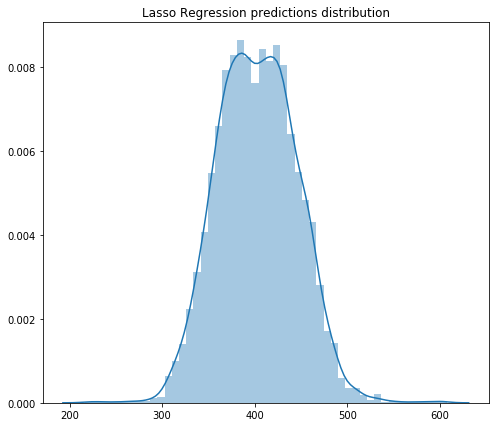

In [13]:
plt.figure(figsize=(8,7))
sns.distplot(lasso_reg.predict(X_test))
plt.title('Lasso Regression predictions distribution')
plt.show()

**RandomForestRegressor**

RFRegressor MSE=206.80732781132076 MAE=11.038509433962263 on fold =1
RFRegressor MSE=161.7525002264151 MAE=9.629298113207547 on fold =2
RFRegressor MSE=158.72964781132075 MAE=9.544841509433962 on fold =3
RFRegressor MSE=176.57472818867922 MAE=9.631422641509435 on fold =4
RFRegressor MSE=129.73761143396226 MAE=8.636275471698113 on fold =5
RFRegressor MSE=134.76354796226414 MAE=8.585603773584905 on fold =6
RFRegressor MSE=109.79558883018869 MAE=7.973064150943397 on fold =7
RFRegressor MSE=120.40788841509433 MAE=8.191875471698113 on fold =8
RFRegressor MSE=120.18758011320756 MAE=8.156690566037737 on fold =9
RFRegressor MSE=137.37210135849057 MAE=8.647645283018868 on fold =10

[11.038509433962263, 9.629298113207547, 9.544841509433962, 9.631422641509435, 8.636275471698113, 8.585603773584905, 7.973064150943397, 8.191875471698113, 8.156690566037737, 8.647645283018868]

RFRegressor mean MAE= 9.003522641509434


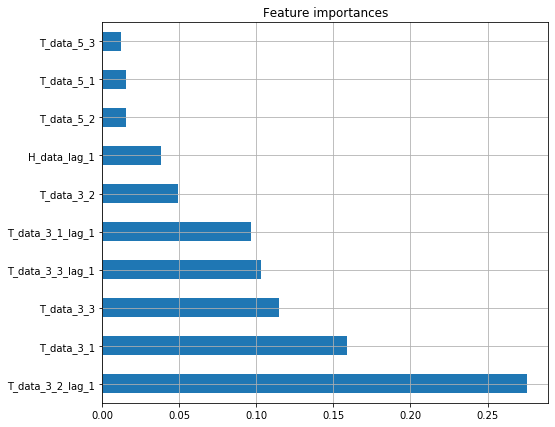

In [14]:
rf_reg = rf_cross_val(X, y, 10)

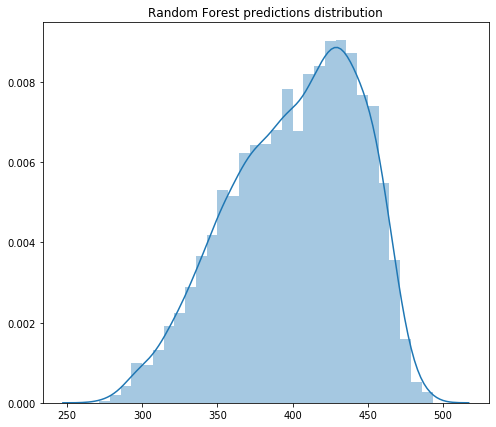

In [15]:
plt.figure(figsize=(8,7))
sns.distplot(rf_reg.predict(X_test))
plt.title('Random Forest predictions distribution')
plt.show()

**XGBMRegressor**

XGBRegressor MSE=147.70320672734448 MAE=9.077562762566332 on fold =1
XGBRegressor MSE=136.8215958794238 MAE=8.780834603939416 on fold =2
XGBRegressor MSE=137.02309529585554 MAE=8.769607682138119 on fold =3
XGBRegressor MSE=146.96604419210468 MAE=8.943041301223467 on fold =4
XGBRegressor MSE=111.80066778102046 MAE=7.999295619748674 on fold =5
XGBRegressor MSE=131.3545910560199 MAE=8.18091760023585 on fold =6
XGBRegressor MSE=99.90139319422778 MAE=7.504613209850383 on fold =7
XGBRegressor MSE=133.16421887654988 MAE=8.368140120596255 on fold =8
XGBRegressor MSE=121.43749985887405 MAE=8.05367613594487 on fold =9
XGBRegressor MSE=134.81444232141916 MAE=8.557170847766804 on fold =10

[9.077562762566332, 8.780834603939416, 8.769607682138119, 8.943041301223467, 7.999295619748674, 8.18091760023585, 7.504613209850383, 8.368140120596255, 8.05367613594487, 8.557170847766804]

XGBRegressor mean MAE= 8.423485988401016


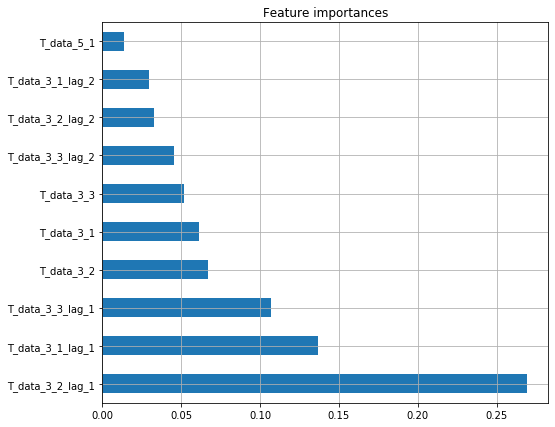

In [16]:
xgb_reg = xgb_cross_val(X, y, 10)

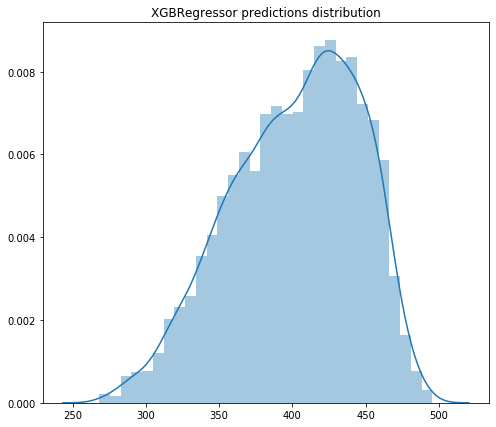

In [17]:
plt.figure(figsize=(8,7))
sns.distplot(xgb_reg.predict(X_test))
plt.title('XGBRegressor predictions distribution')
plt.show()

**LGBMRegressor**

XGBRegressor MSE=145.87365402230878 MAE=9.03788921407745 on fold =1
XGBRegressor MSE=126.43332206696647 MAE=8.447669103256649 on fold =2
XGBRegressor MSE=120.05193263664528 MAE=8.219525664364584 on fold =3
XGBRegressor MSE=122.99955907301248 MAE=8.129639842089246 on fold =4
XGBRegressor MSE=97.90939879116522 MAE=7.456982604343192 on fold =5
XGBRegressor MSE=114.0865840707397 MAE=7.708343157813877 on fold =6
XGBRegressor MSE=83.21017598430083 MAE=6.889766921038615 on fold =7
XGBRegressor MSE=106.70978626356298 MAE=7.643981372632682 on fold =8
XGBRegressor MSE=102.65711122180281 MAE=7.427798405282097 on fold =9
XGBRegressor MSE=111.46075390782644 MAE=7.801178010161874 on fold =10

[9.03788921407745, 8.447669103256649, 8.219525664364584, 8.129639842089246, 7.456982604343192, 7.708343157813877, 6.889766921038615, 7.643981372632682, 7.427798405282097, 7.801178010161874]

XGBRegressor mean MAE= 7.876277429506027


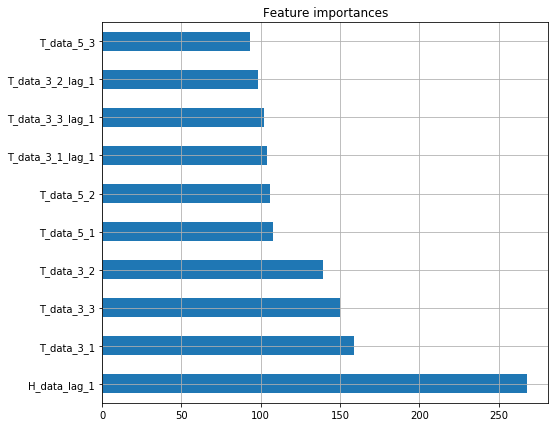

In [18]:
lgb_reg = lgb_cross_val(X, y, 10)

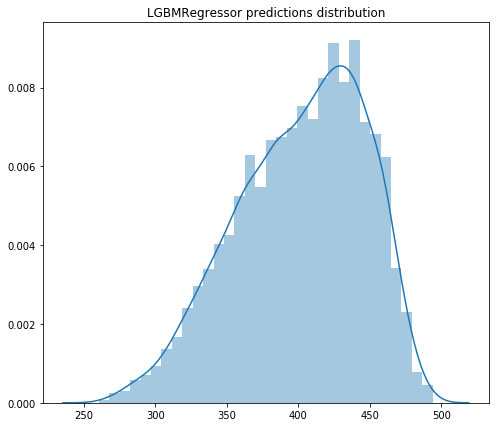

In [19]:
plt.figure(figsize=(8,7))
sns.distplot(lgb_reg.predict(X_test))
plt.title('LGBMRegressor predictions distribution')
plt.show()

**CatBoostRegressor**

CatBoostRegressor MSE=121.51912235219703 MAE=8.1415300589075 on fold =1
CatBoostRegressor MSE=105.55981933493567 MAE=7.577517553685002 on fold =2
CatBoostRegressor MSE=93.7712202387556 MAE=7.3093558723492 on fold =3
CatBoostRegressor MSE=104.6748299534017 MAE=7.488451075223927 on fold =4
CatBoostRegressor MSE=82.14766173971178 MAE=6.911363373444366 on fold =5
CatBoostRegressor MSE=89.55419459906322 MAE=6.929812943593935 on fold =6
CatBoostRegressor MSE=67.43935816871083 MAE=6.119263399687992 on fold =7
CatBoostRegressor MSE=86.50990745842502 MAE=6.768205920859338 on fold =8
CatBoostRegressor MSE=80.61130978035426 MAE=6.603190091038645 on fold =9
CatBoostRegressor MSE=88.94671514327052 MAE=6.994920478442127 on fold =10

[8.1415300589075, 7.577517553685002, 7.3093558723492, 7.488451075223927, 6.911363373444366, 6.929812943593935, 6.119263399687992, 6.768205920859338, 6.603190091038645, 6.994920478442127]

CatBoostRegressor mean MAE= 7.084361076723203


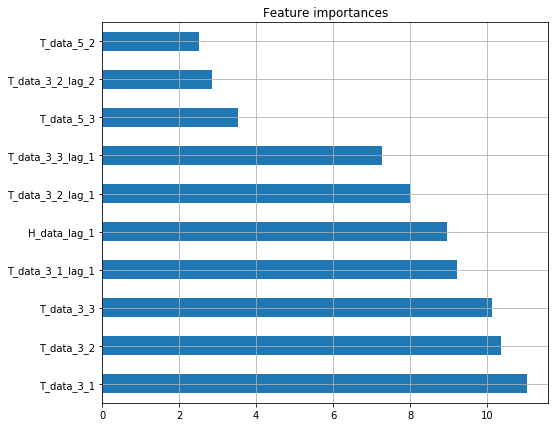

In [20]:
cat_reg = catboost_cross_val(X, y, 10)

А вот так выглядит распределение предикшена лучшей модели. Очень похоже на правду, но на средние значения модель немного переобучились

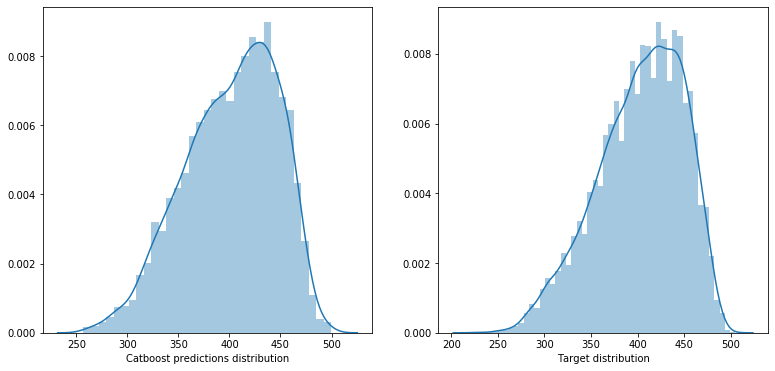

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
sns.distplot(cat_reg.predict(X_test), axlabel='Catboost predictions distribution', ax=ax[0])
sns.distplot(df_train.target, axlabel='Target distribution', ax=ax[1])
plt.show()

- Что не зашло? Скейлинг фич (качество только ухудшилось), rolling window (min, max, mean) усложнили модель, но не дали результата, GridSearchCV (гридсерчил очень много параметров, но никакая комбинация не дала статистически значимого лучшего результата), PCA + регрессия (думал, что если сжать признаки датчиков в одних камерах, можно будет добиться лучшего результата, но нет)
- Что очень зашло? Лаговые фичи!
- Лучшая модель? CatBoost, причем с дефолтными параметрами

## SUBMISSION

In [22]:
y = df_train['target'].iloc[24:]
X = df_train.iloc[24:, :-1]
X_test = df_test.drop('target', axis=1).reset_index()

model = CatBoostRegressor(silent=True)
model.fit(X, y)
X_test['target'] = model.predict(X_test).astype(int)
submission = X_test.iloc[:, [0,-1]]
submission.to_csv('Y_submit_mamed.csv', index=False)

## Спасибо за внимание!